# Introduction


In this notebook, we implement [The TensorFlow 2 Object Detection Library](https://blog.tensorflow.org/2020/07/tensorflow-2-meets-object-detection-api.html) for training on your own dataset.

We also recommend reading our blog post on [Train TensorFlow 2 Object Detection on custom data](https://blog.roboflow.ai/training-yolov4-on-a-custom-dataset/) side by side.

We will take the following steps to implement YOLOv4 on our custom data:
* Install TensorFlow2 Object Detection Dependencies
* Download Custom TensorFlow2 Object Detection Dataset
* Write Custom TensorFlow2 Object Detection Training Configuation
* Train Custom TensorFlow2 Object Detection Model
* Export Custom TensorFlow2 Object Detection Weights
* Use Trained TensorFlow2 Object Detection For Inference on Test Images

When you are done you will have a custom detector that you can use. It will make inference like this:

#### ![Roboflow Workmark](https://i.imgur.com/L0n564N.png)

### **Reach out for support**

If you run into any hurdles on your own data set or just want to share some cool results in your own domain, [reach out!](https://roboflow.ai) 



#### ![Roboflow Workmark](https://i.imgur.com/WHFqYSJ.png)

# Install TensorFlow2 Object Detection Dependencies

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2402, done.
remote: Counting objects: 100% (2402/2402), done.
remote: Compressing objects: 100% (1997/1997), done.
remote: Total 2402 (delta 560), reused 1461 (delta 378), pack-reused 0
Receiving objects: 100% (2402/2402), 30.78 MiB | 27.12 MiB/s, done.
Resolving deltas: 100% (560/560), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1608663 sha256=8a5e76d0c8776e3664195a71f973ac15790a36e6318357199532f8e7b5ddee85
  Stored in directory: /tmp/pip-ephem-wheel-cache-cbm2y1wz/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp36-none-any.whl size=43734 sha256=3b73410bffd6903abc101bc2578da8d2dab39427d4a69c06c357e8adb08d3977
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=9cc49dacf1e1d7f76838ec66cb0d307498654f4e14cda8b8265128c7a54cd3eb
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78533 sha256=4f78d660f6fce0d35f8fd0f41f3d8328d75aa77e858316f0c945

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.27.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
#run model builder test
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py


2021-01-15 09:57:30.250267: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2021-01-15 09:57:32.668027: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-15 09:57:32.669254: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-15 09:57:32.726580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-15 09:57:32.727210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB devic

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

# Prepare Tensorflow 2 Object Detection Training Data


Roboflow automatically creates our TFRecord and label_map files that we need!

**Generating your own TFRecords the only step you need to change for your own custom dataset.**

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

To create a dataset in Roboflow and generate TFRecords, follow [this step-by-step guide](https://blog.roboflow.ai/getting-started-with-roboflow/).




![](https://i.imgur.com/ZwMdcbY.png)

In [ ]:
#Downloading data from Roboflow
#UPDATE THIS LINK - get our data from Roboflow
%cd /content
!curl -L "https://app.roboflow.com/ds/fe8aqwb2jA?key=QJ9Ze96upL" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1076      0 --:--:-- --:--:-- --:--:--  1076
100 9145k  100 9145k    0     0  6902k      0  0:00:01  0:00:01 --:--:--  358M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/sperm.tfrecord     
 extracting: test/sperm_label_map.pbtxt  
   creating: train/
 extracting: train/sperm.tfrecord    
 extracting: train/sperm_label_map.pbtxt  


In [ ]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/test/sperm.tfrecord'
train_record_fname = '/content/train/sperm.tfrecord'
label_map_pbtxt_fname = '/content/train/sperm_label_map.pbtxt'

# Configure Custom TensorFlow2 Object Detection Training Configuration




> In this section you can specify any model in the [TF2 OD model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) and set up your training configuration.



In [ ]:
##change chosen model to deploy different models available in the TF2 object detection zoo
MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 16
    }
}

#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'efficientdet-d0'
num_image = 463
batch_size = 16
num_steps = int(850 * (num_image / batch_size))  # 200000 to improve # The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps
print(num_steps)
model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

24596


In [ ]:
#download pretrained weights
%mkdir /content/models/research/deploy/
%cd /content/models/research/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

/content/models/research/deploy
--2021-01-15 09:58:04--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.195.128, 2607:f8b0:400e:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.195.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M  73.7MB/s    in 0.4s    

2021-01-15 09:58:04 (73.7 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]



In [ ]:
#download base training configuration file
%cd /content/models/research/deploy
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

/content/models/research/deploy
--2021-01-15 09:58:05--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4630 (4.5K) [text/plain]
Saving to: ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config’

ssd_efficientdet_d0 100%[===================>]   4.52K  --.-KB/s    in 0s      

2021-01-15 09:58:05 (72.1 MB/s) - ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config’ saved [4630/4630]



In [ ]:
#prepare
pipeline_fname = '/content/models/research/deploy/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)
print(num_classes)

2


In [ ]:
#write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file

import re

%cd /content/models/research/deploy
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)



/content/models/research/deploy
writing custom configuration file


In [ ]:
%cat /content/models/research/deploy/pipeline_file.config

 # SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from an EfficientNet-b0 checkpoint.
#
# Train on TPU-8

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 2
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      m

In [ ]:
pipeline_file = '/content/models/research/deploy/pipeline_file.config'
model_dir = '/content/training/'

# Train Custom TF2 Object Detector

* pipeline_file: defined above in writing custom training configuration
* model_dir: the location tensorboard logs and saved model checkpoints will save to
* num_train_steps: how long to train for
* num_eval_steps: perform eval on validation set after this many steps







In [ ]:
import time
secs = time.time()
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}\
    --checkpoint_every_n=500\
    --eval_on_train_data

now = (time.time() - secs) / 3600
print(now)

2021-01-15 09:58:06.076398: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-01-15 09:58:08.527985: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-15 09:58:08.529166: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-15 09:58:08.567040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-15 09:58:08.567650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2021-01-15 09:58:08.567692: I tensorflow/stream_executor/platform/default/dso_loade

In [ ]:
#write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file

import re

%cd /content/models/research/deploy
print('writing custom configuration file')
batch_size = 1
with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)


    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)


In [ ]:
%cat /content/models/research/deploy/pipeline_file.config

In [ ]:
#run model evaluation to obtain performance metrics
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir}
#Not yet implemented for EfficientDet

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/training/train'

## Exporting a Trained Inference Graph
Still to come for TF2 models, we will be updating this Colab notebook accordingly as the functionality is added. 

In [ ]:

#see where our model saved weights
%ls '/content/training/'

In [ ]:
#run conversion script
import re
import numpy as np

output_directory = '/content/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/training/'
lst = os.listdir(last_model_path)
lst = [l for l in lst if 'ckpt-' in l and '.index' not in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
print(steps, lst)
last_model = lst[steps.argmax()]

print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

In [ ]:
%ls '/content/fine_tuned_model/saved_model/'

# Run Inference on Test Images with Custom TensorFlow2 Object Detector

In [ ]:
#downloading test images from Roboflow
#export dataset above with format COCO JSON
#or import your test images via other means. 
%mkdir /content/test/
%cd /content/test/
!curl -L "https://app.roboflow.com/ds/biMXtaEOQr?key=hVyySqZApE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


mkdir: cannot create directory ‘/content/test/’: File exists
/content/test
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   886  100   886    0     0   1356      0 --:--:-- --:--:-- --:--:--  1354
100  590k  100  590k    0     0   701k      0 --:--:-- --:--:-- --:--:--  701k
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/CuneytBulgur-11_jpeg.rf.4deb112bbad1cf2731cf114879a443e8.jpg  
 extracting: test/CuneytBulgur-11_jpeg.rf.4deb112bbad1cf2731cf114879a443e8.xml  
 extracting: test/CuneytBulgur-12_jpeg.rf.cc5491ec5bb12940ce2b80fcf0b45f33.jpg  
 extracting: test/CuneytBulgur-12_jpeg.rf.cc5491ec5bb12940ce2b80fcf0b45f33.xml  
 extracting: test/CuneytBulgur-13_jpeg.rf.3bbe98cce09c19487e9fa7a18c98db5a.jpg  
 extracting: test/CuneytBulgur-13_jpeg.rf.3bbe98cce09c19487e9fa7a18c98db5a.xml  
 extracting: test/CuneytBulgur-14_jpeg.rf.e

In [ ]:

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline
from tensorflow.python.summary.summary_iterator import summary_iterator
for e in summary_iterator("/content/training/eval/events.out.tfevents.1609368975.9c4fc9b95219.337.6104.v2"):
    for v in e.summary.value:
        print(v.tag)

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
%ls '/content/training/'

checkpoint                  ckpt-2.index                ckpt-4.index
ckpt-1.data-00000-of-00001  ckpt-3.data-00000-of-00001  train/
ckpt-1.index                ckpt-3.index
ckpt-2.data-00000-of-00001  ckpt-4.data-00000-of-00001


In [ ]:
#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = '/content/training/ckpt-4'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join('/content/training/ckpt-4'))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [ ]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

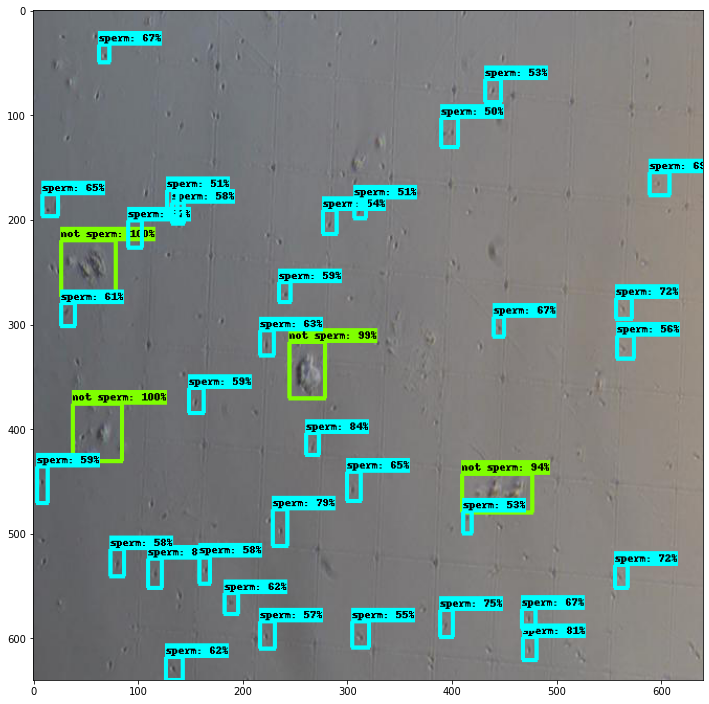

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random

TEST_IMAGE_PATHS = glob.glob('/content/test/test/*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [ ]:
!zip -r /content/fine_tuned_model /content/fine_tuned_model
!zip -r /content/training /content/training

!mkdir "/content/video-3-efficient-20-80"
!cd "/content/video-3-efficient-20-80"

!cp /content/fine_tuned_model.zip "/content/video-3-efficient-20-80/"
!cp /content/training.zip "/content/video-3-efficient-20-80"
!zip -r /content/video-3-efficient-20-80 /content/video-3-efficient-20-80

  adding: content/fine_tuned_model/ (stored 0%)
  adding: content/fine_tuned_model/saved_model/ (stored 0%)
  adding: content/fine_tuned_model/saved_model/saved_model.pb (deflated 93%)
  adding: content/fine_tuned_model/saved_model/assets/ (stored 0%)
  adding: content/fine_tuned_model/saved_model/variables/ (stored 0%)
  adding: content/fine_tuned_model/saved_model/variables/variables.index (deflated 78%)
  adding: content/fine_tuned_model/saved_model/variables/variables.data-00000-of-00001 (deflated 36%)
  adding: content/fine_tuned_model/pipeline.config (deflated 68%)
  adding: content/fine_tuned_model/checkpoint/ (stored 0%)
  adding: content/fine_tuned_model/checkpoint/ckpt-0.data-00000-of-00001 (deflated 36%)
  adding: content/fine_tuned_model/checkpoint/ckpt-0.index (deflated 80%)
  adding: content/fine_tuned_model/checkpoint/checkpoint (deflated 42%)
  adding: content/training/ (stored 0%)
  adding: content/training/ckpt-23.data-00000-of-00001 (deflated 36%)
  adding: content/t

In [ ]:
while True:
  continue

KeyboardInterrupt: ignored

## Congrats!

Hope you enjoyed this!

--Team [Roboflow](https://roboflow.ai)
